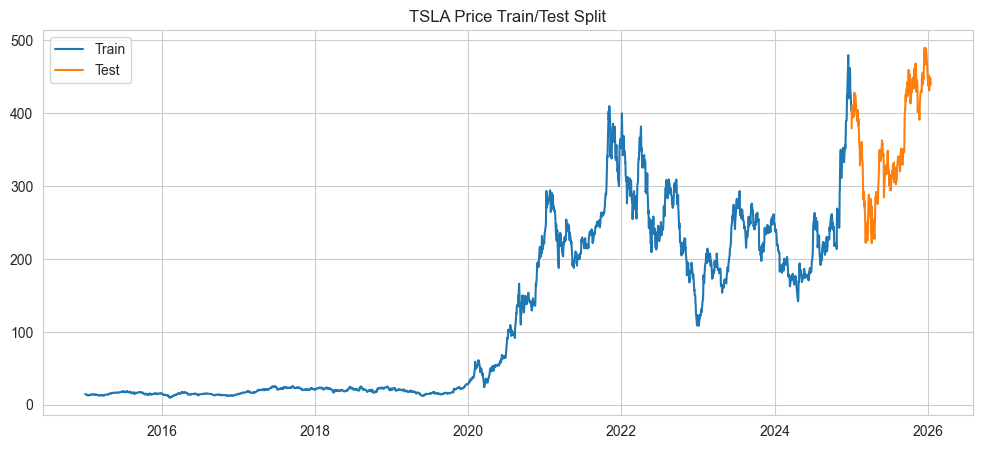

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16374.056, Time=2.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16368.573, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16370.458, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16370.460, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16368.109, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16372.458, Time=0.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.113 seconds
ARIMA order: (0, 1, 0)


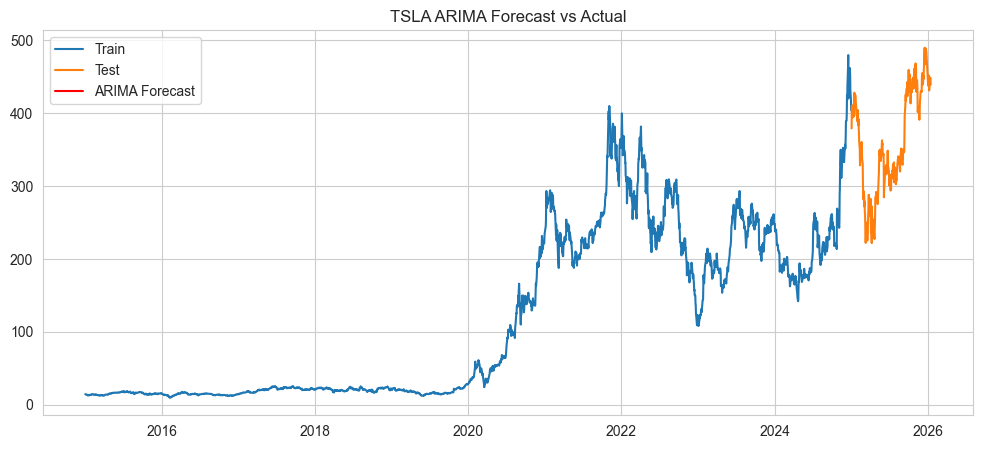

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0121 - val_loss: 0.0026
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


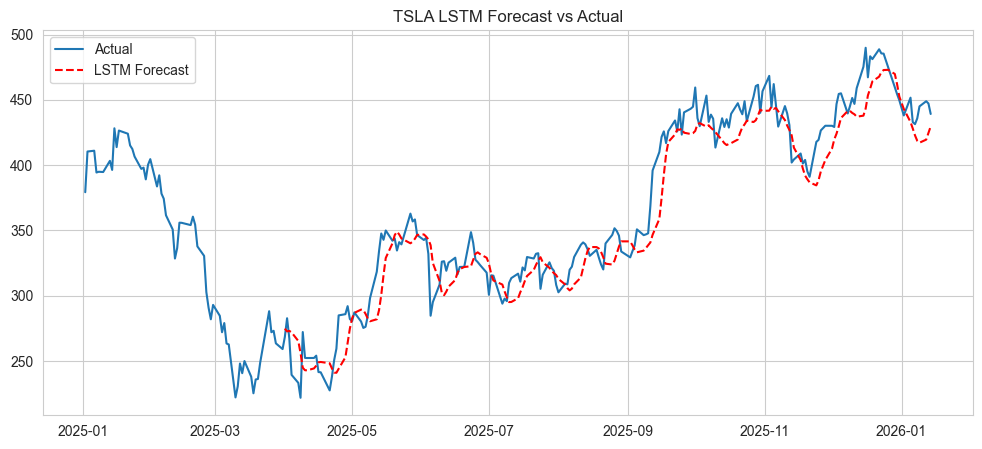

ARIMA -> MAE: nan, RMSE: nan, MAPE: nan%
LSTM -> MAE: 14.66, RMSE: 18.50, MAPE: 4.09%
Forecasts saved for ARIMA and LSTM.


In [13]:
# ================================
# Task 2: Time Series Forecasting Models
# ================================

# -------------------------
# 1. Imports
# -------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# -------------------------
# 2. Load Preprocessed Data
# -------------------------
closes = pd.read_csv("../data/processed/historical_prices.csv", index_col="Date", parse_dates=True)
returns = pd.read_csv("../data/processed/daily_returns.csv", index_col="Date", parse_dates=True)

tsla_prices = closes["TSLA"]

# -------------------------
# 3. Train-Test Split
# -------------------------
# Chronological split: train 2015-2024, test 2025-2026
train_data = tsla_prices.loc[:'2024-12-31']
test_data = tsla_prices.loc['2025-01-01':]

plt.figure(figsize=(12,5))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.title("TSLA Price Train/Test Split")
plt.legend()
plt.show()

# -------------------------
# 4. ARIMA Forecast
# -------------------------
# Auto ARIMA to select best p,d,q
arima_model = auto_arima(train_data, seasonal=False, trace=True, stepwise=True)
print("ARIMA order:", arima_model.order)

# Fit ARIMA
arima_model.fit(train_data)
arima_forecast = pd.Series(arima_model.predict(n_periods=len(test_data)), index=test_data.index)

# Plot ARIMA
plt.figure(figsize=(12,5))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(arima_forecast, label='ARIMA Forecast', color='red')
plt.title("TSLA ARIMA Forecast vs Actual")
plt.legend()
plt.show()

# -------------------------
# 5. LSTM Forecast
# -------------------------
# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data.values.reshape(-1,1))
test_scaled = scaler.transform(test_data.values.reshape(-1,1))

# Create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i,0])
        y.append(data[i,0])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

seq_length = 60
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(seq_length,1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)
lstm_model.save("../models/lstm_tsla_model.h5")

# Predict
y_pred_scaled = lstm_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

# Align predictions
lstm_forecast = pd.Series(np.nan, index=test_data.index)
lstm_forecast[seq_length:] = y_pred.flatten()

# Plot
plt.figure(figsize=(12,5))
plt.plot(tsla_prices.loc['2025-01-01':], label='Actual')
plt.plot(lstm_forecast, label='LSTM Forecast', color='red', linestyle='--')
plt.title("TSLA LSTM Forecast vs Actual")
plt.legend()
plt.show()

# -------------------------
# 6. Evaluate Models
# -------------------------
def evaluate(y_true, y_pred, name="Model"):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    return mae, rmse, mape

# ARIMA Evaluation
evaluate(test_data.values, arima_forecast.values, "ARIMA")

# LSTM Evaluation
y_true_aligned = test_data.values[seq_length:]
evaluate(y_true_aligned, y_pred, "LSTM")

# -------------------------
# 7. Save Forecasts
# -------------------------
arima_forecast.to_csv("../data/processed/tsla_arima_forecast.csv", header=['Forecast'])
lstm_forecast.to_csv("../data/processed/tsla_lstm_forecast.csv", header=['Forecast'])
print("Forecasts saved for ARIMA and LSTM.")
